In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score


truck = pd.read_csv('fleet_truck.csv', header = 0)

In [2]:
import matplotlib.pyplot as plt
import numpy
import pandas
import statsmodels.api as smodel

from sklearn import metrics
from sklearn import tree

from sklearn.model_selection import train_test_split

from scipy.stats import chi2

### 1. Select columns with more than one distinct observations (0:26)

In [3]:
truck = truck.iloc[:,0:26]
truck.shape

(8307, 26)

### 2. Drop one of the collinear pairs

In [4]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(truck, 10))

Top Absolute Correlations
Vibration        Speed_OBD        1.000000
Speed_sensor     Vibration        1.000000
                 Speed_OBD        1.000000
Intake_Pressure  Turbo_Boost      0.999954
Litres_Per_km    CO2              0.998375
Trip_Distance    Trip_Time        0.994790
Speed_OBD        Speed_GPS        0.985869
Speed_sensor     Speed_GPS        0.985869
Vibration        Speed_GPS        0.985869
GPS_Altitude     Trip_Distance    0.868121
dtype: float64


In [5]:
# threshold 0.9
truck = truck.drop(['Vibration', 'Speed_OBD', 'Turbo_Boost', 'CO2', \
                   'Speed_GPS', 'Trip_Time'], axis = 1)
truck.shape

(8307, 20)

### 3. Look at coefficient of variation

If the interval features are likely to be constant, drop it

In [6]:
result = pd.DataFrame()
for thisVar in truck.iloc[:,1:26].columns:
    minimum = min(truck[thisVar])
    maximum = max(truck[thisVar])
    mean = np.mean(truck[thisVar])
    std = np.std(truck[thisVar], ddof = 1)
    coefVar = std / max(1.0, abs(mean))
    if mean < 0:
        coefVar = -coefVar
  
    result = result.append([[thisVar, minimum, maximum, mean, std, \
                            coefVar]],ignore_index = True)

result = result.rename(columns= {0:'Feature Field', 1: 'minimum', 
                                 2: 'maximum', 3: 'mean',
                                 4: 'std', 5 :'Coefficient of Variation'})
result
result.sort_values(by='Coefficient of Variation')

,Feature Field,minimum,maximum,mean,std,Coefficient of Variation
18,Accel_Ssor_Total,-0.735121,0.460050,-0.003159,0.063671,-0.063671
13,GPS_Latitude,47.022808,49.813540,48.547051,0.571127,0.011764
8,Voltage,9.940000,14.460000,14.171672,0.219311,0.015475
2,Coolant_Temp,79.000000,94.000000,87.736006,2.200520,0.025081
11,Engine_Oil_Temp,74.000000,92.000000,84.526905,2.318508,0.027429
12,GPS_Longitude,6.537594,10.216362,8.569920,0.640588,0.074748
7,Throttle_Pos,9.803922,89.019610,75.258476,9.414729,0.125099
9,Ambient,5.000000,9.000000,7.309739,0.915003,0.125176
3,Intake_Pressure,99.000000,255.000000,119.411340,20.573149,0.172288
5,Intake_Air,6.000000,18.000000,10.664139,2.500781,0.234504


In [7]:
# threshold 0.1
truck = truck.drop(['GPS_Latitude', 'Voltage', 'Coolant_Temp', 'Engine_Oil_Temp',\
                    'Accel_Ssor_Total', 'GPS_Longitude'], axis = 1)
truck.shape

(8307, 14)

### 4. Look at variety among catagories

In [8]:
result = pd.DataFrame()
for thisVar in truck.iloc[:,1:26].columns:
    thisDType = truck[thisVar].dtypes
    
    
    nRow = truck.shape[0]
    nNaN = truck[thisVar].isna().sum()
    percentNaN = 100.0 * (nNaN / nRow)
    
    entropy = np.NaN
    persentEntropy = np.NaN
    mean = np.NaN
    coefVar = np.NaN
    
    uniqueValue = truck[thisVar].value_counts()
    nValid = np.sum(uniqueValue)
    uniqueProp = uniqueValue / nValid
    nUnique = uniqueValue.size
    
    entropy = - np.sum(uniqueProp * np.log2(uniqueProp))
    if nUnique > 1:
        e0 = nValid - nUnique + 1
        e0 = np.log2(nValid) - (e0 / nValid) * np.log2(e0)
        e1 = np.log2(nUnique)
        if e1 > e0:
            percentEntropy = 100.0 * ((entropy - e0) / (e1 - e0))
    
    
    result = result.append([[thisVar, thisDType, nValid, nNaN, percentNaN, \
                             nUnique, entropy, percentEntropy]],ignore_index = True)

result = result.rename(columns= {0:'Feature Field', 1: 'DType', 
                                 2: 'Number of Valids', 3: 'Number of NaNs',
                                 4: 'Percent of NaNs', 5: 'Number of Unique Values',
                                 6: 'Entropy', 7: 'Percent of Entropy'})
result
result.sort_values(by='Percent of Entropy')

,Feature Field,DType,Number of Valids,Number of NaNs,Percent of NaNs,Number of Unique Values,Entropy,Percent of Entropy
12,Litres_Per_km,float64,8149,158,1.90201,5399,10.091617,29.308033
8,Accel,float64,8307,0,0.00000,114,3.354689,47.588151
6,Throttle_Pos,float64,8307,0,0.00000,127,3.539117,49.042356
2,Intake_Pressure,int64,8307,0,0.00000,148,5.327404,72.934743
7,Ambient,int64,8307,0,0.00000,5,1.905363,82.005557
10,GPS_Altitude,int64,8307,0,0.00000,628,8.157356,86.143091
4,Intake_Air,int64,8307,0,0.00000,13,3.212051,86.726943
11,Trip_Distance,float64,8307,0,0.00000,7171,12.685931,89.634428
1,Engine_Load,float64,8307,0,0.00000,256,7.217843,89.649525
5,Flow_Rate,float64,8307,0,0.00000,1488,9.866022,91.559266


### Drop missing values

In [9]:
truck = truck.dropna(axis = 0)
truck.shape

(8149, 14)

In [10]:
truck

,Maintenance_flag,Speed_sensor,Engine_Load,Intake_Pressure,Engine_RPM,Intake_Air,Flow_Rate,Throttle_Pos,Ambient,Accel,GPS_Bearing,GPS_Altitude,Trip_Distance,Litres_Per_km
0,0,35,21.568628,116,1115.5,10,18.33,80.000000,7,27.843138,75.2,164,310.26200,2.351502
1,0,142,20.392157,135,1782.5,16,35.41,80.000000,8,34.509804,274.4,436,161.02463,1.244649
2,0,128,43.529410,109,1588.0,9,27.08,80.000000,8,14.901961,257.1,508,158.23788,2.124100
3,0,117,99.607840,128,1899.5,13,36.99,80.000000,7,43.921570,330.7,618,148.82233,0.000000
4,0,98,73.333336,123,1230.5,9,21.63,80.000000,7,14.901961,3.0,154,296.00378,4.031921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8302,0,95,0.000000,109,1158.5,12,21.16,80.000000,7,14.901961,306.4,335,174.84918,0.000000
8303,0,8,29.019608,105,691.0,10,9.13,69.019610,8,14.901961,311.7,386,170.63930,22.071579
8304,1,66,55.686275,126,1575.5,13,30.16,69.411766,7,32.941177,7.5,153,290.90314,6.450333
8305,1,75,46.274510,109,1412.0,8,24.11,80.000000,6,14.901961,354.7,146,271.84190,3.525263


X = truck.iloc[:, 1:]
y = truck.iloc[:, 0]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [11]:
#np.mean(y_train)

In [12]:
#np.mean(y_test)

In [13]:
#truck['Maintenance_flag'] = truck['Maintenance_flag'].map({0: "No",1: "Yes"})


In [14]:
#truck

In [15]:
truck.dtypes

Maintenance_flag      int64
Speed_sensor          int64
Engine_Load         float64
Intake_Pressure       int64
Engine_RPM          float64
Intake_Air            int64
Flow_Rate           float64
Throttle_Pos        float64
Ambient               int64
Accel               float64
GPS_Bearing         float64
GPS_Altitude          int64
Trip_Distance       float64
Litres_Per_km       float64
dtype: object

In [16]:
X = truck.iloc[:, 1:]
y = truck.iloc[:, 0]

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [18]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [19]:
u = y_train.astype('category')
y_cat = u.cat.categories



## train

In [20]:
def BinaryMetric (y, y_cat, predProbY, ppY_threshold):
   predClass = numpy.where(predProbY >= ppY_threshold, y_cat[1], y_cat[0])
   MCE = numpy.mean(numpy.where(predClass == y, 0, 1))
   error = numpy.where(y == y_cat[1], 1.0 - predProbY, -predProbY)
   RASE = numpy.sqrt(numpy.mean(error * error))
   AUC = metrics.roc_auc_score(y, predProbY)
   return (MCE, RASE, AUC) 

In [21]:
objTree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_leaf = 5, random_state = 60637)
modelTree = objTree.fit(X_train, y_train)
ppY_train_Tree = modelTree.predict_proba(X_train)
pred_train_Tree = modelTree.predict(X_train)


In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_train, pred_train_Tree)
MCE_train_Tree, RASE_train_Tree, AUC_train_Tree = BinaryMetric(y_train, y_cat, ppY_train_Tree[:,1], 0.22948807854137449)
print(cm)
print("Accuracy: ",accuracy_score(y_train, pred_train_Tree))
print("RASE: ",RASE_train_Tree)
print("AUC: ",AUC_train_Tree)

[[3671  724]
 [ 257 1052]]
Accuracy:  0.8280154277699859
RASE:  0.3189802457477759
AUC:  0.8950155178422594


In [23]:
fpr_train_Tree, tpr_train_Tree, thresh_train_Tree = metrics.roc_curve(y_train, ppY_train_Tree[:,1], pos_label = y_cat[1])

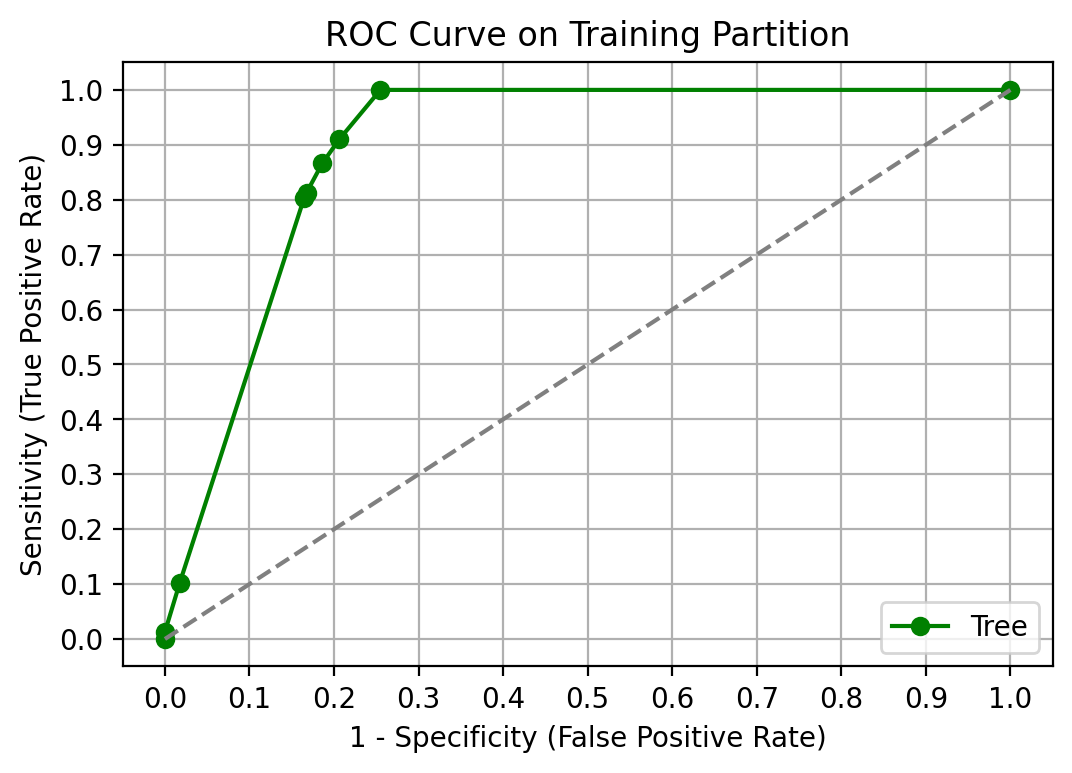

In [24]:
plt.figure(dpi = 200)
plt.plot(fpr_train_Tree, tpr_train_Tree, marker = 'o', color = 'green', label = 'Tree')
plt.plot([0,1], [0,1], linestyle = 'dashed', color = 'gray')
plt.title('ROC Curve on Training Partition')
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xticks(numpy.arange(0,1.1,0.1))
plt.yticks(numpy.arange(0,1.1,0.1))
plt.grid(axis = 'both')
plt.legend(loc = 'lower right')
plt.show()

## test

In [25]:
objTree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_leaf = 5, random_state = 60637)
modelTree = objTree.fit(X_test, y_test)
ppY_test_Tree = modelTree.predict_proba(X_test)
pred_test_Tree = modelTree.predict(X_test)

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, pred_test_Tree)
MCE_test_Tree, RASE_test_Tree, AUC_test_Tree = BinaryMetric(y_test, y_cat, ppY_test_Tree[:,1], 0.2282208588957055)
print(cm)
print("Accuracy: ",accuracy_score(y_test, pred_test_Tree))
print("RASE: ",RASE_test_Tree)
print("AUC: ",AUC_test_Tree)

[[1470  417]
 [   1  557]]
Accuracy:  0.8290388548057259
RASE:  0.30845832839053805
AUC:  0.9058821629979126


In [28]:
fpr_test_Tree, tpr_test_Tree, thresh_test_Tree = metrics.roc_curve(y_test, ppY_test_Tree[:,1], pos_label = y_cat[1])

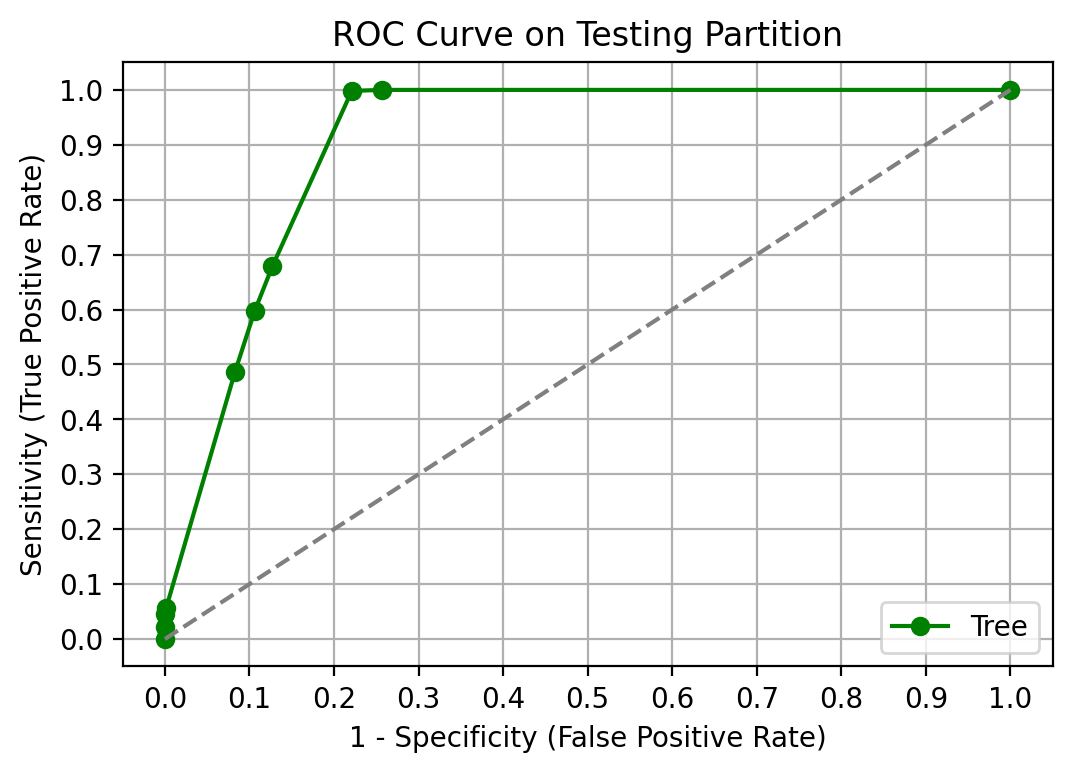

In [31]:
plt.figure(dpi = 200)
plt.plot(fpr_test_Tree, tpr_test_Tree, marker = 'o', color = 'green', label = 'Tree')
plt.plot([0,1], [0,1], linestyle = 'dashed', color = 'gray')
plt.title('ROC Curve on Testing Partition')
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xticks(numpy.arange(0,1.1,0.1))
plt.yticks(numpy.arange(0,1.1,0.1))
plt.grid(axis = 'both')
plt.legend(loc = 'lower right')
plt.show()